
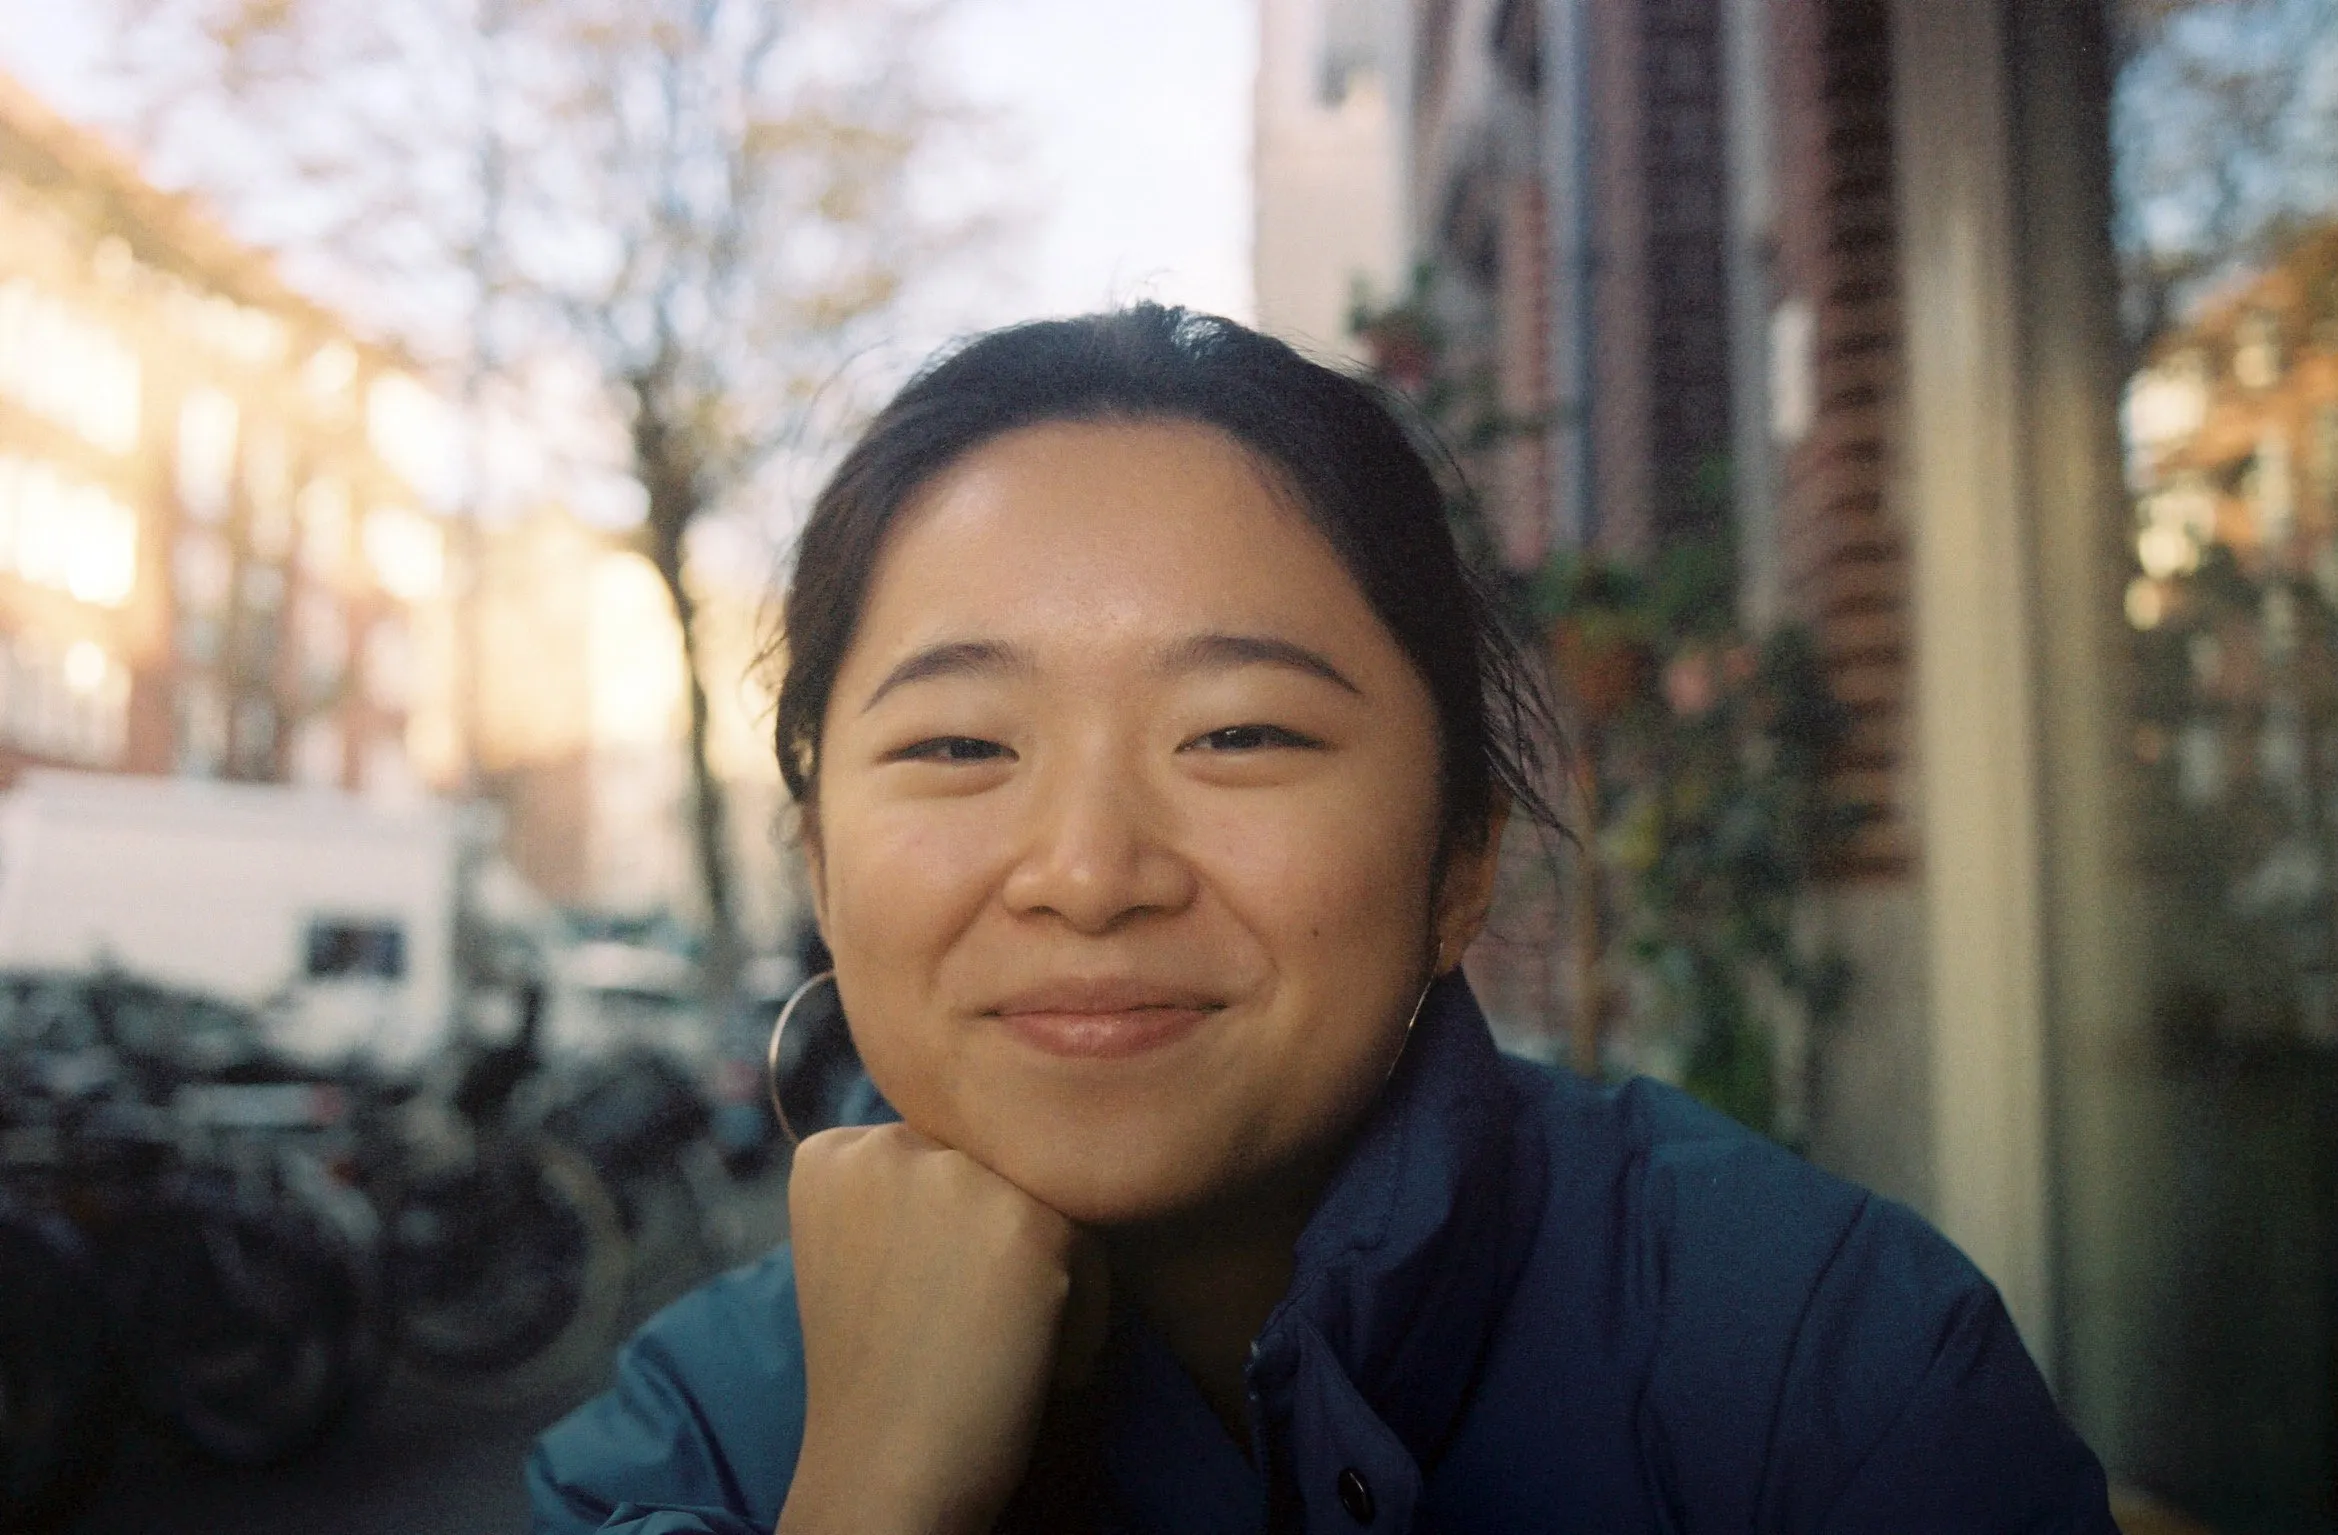
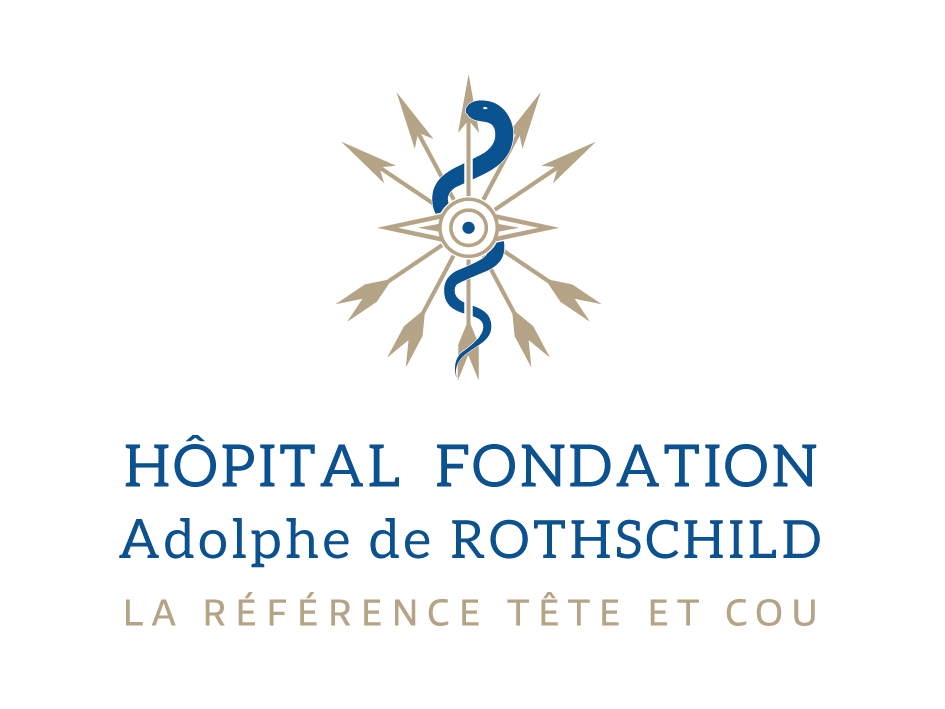
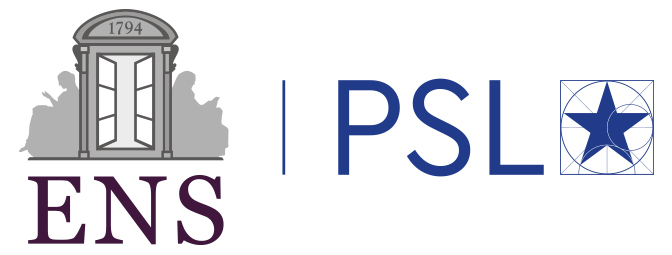

In [1]:
#@title Intro
from IPython.display import display, HTML
from base64 import b64encode

# Main profile image path
main_path = "images/profile_zhang.jpg"

# Two small logos paths
logo1_path = "images/Meta_lockup_positive primary_RGB.png" # Replace with actual paths
logo2_path = "images/rothschild_logo.png"
logo3_path = "images/ENS_PSL.jpg"

# Encode images in base64
def encode_img(path):
    with open(path, "rb") as f:
        return b64encode(f.read()).decode("utf-8")

main_img = encode_img(main_path)
logo1_img = encode_img(logo1_path)
logo2_img = encode_img(logo2_path)
logo3_img = encode_img(logo3_path)

html = f"""
<div style="display: flex; align-items: flex-start; justify-content: space-between;">
    <!-- Left side: profile image and text -->
    <div style="display: flex; align-items: flex-start;">
        <img src="data:image/png;base64,{main_img}" width="200" style="margin-right: 20px;"/>
        <div style="font-size: 24px; font-weight: bold; margin-bottom: 8px;">
            <b>Part 2: Developing efficiently: tmin and caching</b><br>
            <div style="font-size: 18px; line-height: 1.5; font-weight: normal;">
                Lucy (Mingfang) Zhang<br>
                PhD at École normale supérieure - PSL, Paris & Rothschild Foundation Hospital. <br><br>
                Relevant <a href="https://arxiv.org/abs/2502.07429" target="_blank">paper</a>: <br>
                "From Thought to Action: How a Hierarchy of Neural Dynamics Supports Language Production"<br>
                Decoding of linguistic features during continuous natrual language production. Zhang et al. 2025<br><br>
                Keep in touch:
                               <a href="https://www.linkedin.com/in/lucy-mingfang-zhang/" target="_blank">Linkedin</a>,
                               <a href="https://scholar.google.com/citations?view_op=list_works&hl=en&user=23vdTiQAAAAJ" target="_blank">Scholar</a>
            </div>
        </div>
    </div>

    <!-- Right side: two small logos -->
    <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px;">
    <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px; align-items: center;">

        <img src="data:image/png;base64,{logo1_img}" width="200" style="object-fit: contain;" />
        <img src="data:image/png;base64,{logo2_img}" width="100" style="object-fit: contain;" />
        <img src="data:image/png;base64,{logo3_img}" width="100" style="object-fit: contain;" />

    </div>
</div>
"""

display(HTML(html))


In [ ]:
#@title Prep
!pip install mne
!pip install wordfreq
!pip install exca

from pathlib import Path

if not Path("data").exists():
  !gdown 1jkadTwM2FbAojuwjRw_KdMpDoni7l4Xz -O data.zip
  !unzip -q data.zip -d data

!ls data/

import pydantic
import spacy
from pathlib import Path
import mne
import numpy as np
import typing as tp
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import trange
from wordfreq import zipf_frequency

import spacy.cli
spacy.cli.download("en_core_web_lg")

import pandas as pd
from exca import TaskInfra
import time
import copy

# Exca ⚔ - Execution and caching

Documentation: https://facebookresearch.github.io/exca

### Key takeaways:
Exca is a handy tool that allows you to
- modular pipeline with simple building blocks
- cached results so that only missing elements of the array get sent and avoid recomputation
- easy remote computation configuration
- validated configuration before sending to remote  through a job array


# The Goal of this part:

Set up an experimental pipeline that goes from yaml -> results (cache)

Write the previous functions we have into classes + exca (explained in this section)

In [ ]:
DATA_DIR = Path("/content/data")
CACHE_DIR = Path("/content/cache/")

# Neuro class that handles the neural data
class Neuro(pydantic.BaseModel):

    preproc_path: Path
    fmin: float = 0.05
    fmax: float = 40.
    freq: float = 80.
    tmin: float = -.5
    tmax: float = 1.

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def prepare_neuro(self, session: str) -> mne.io.Raw:

        """ Load the raw neuro data and filter """

        file = Path(self.preproc_path) / f"{session}_preproc.fif"

        if file.exists():
            raw = mne.io.read_raw(file, verbose="ERROR")

        else:
            fmin = self.fmin
            fmax = self.fmax
            freq = self.freq

            original_file = self.preproc_path / f"{session}.fif" # original file
            raw = mne.io.read_raw(original_file)
            raw = raw.pick(picks=["meg"]) # don't want to analyse misc

            # band pass filter
            raw = raw.filter(fmin, fmax)

            # downsample
            if freq != raw.info["sfreq"]:
                raw = raw.resample(freq)

        return raw

    def __call__(self, session:str) -> tuple[np.ndarray, list[str]]:

        """ Segment the neural data around words """

        raw = self.prepare_neuro(session)

        events = pd.read_csv(self.preproc_path / "events.csv")

        # Select the words in the relevant session
        words = events[(events['type'] == 'Word') & (events['session'] == session)].dropna().reset_index(drop=True)

        # Get word onsets in samples
        word_onsets = np.ones((len(words), 3), dtype=int) # mne.epochs expects events of shape (n_events, 3) but we are only interested in the first column here -> set the rest to 0
        word_onsets[:, 0] = words.start *raw.info["sfreq"] # first column must contain the onset of each event (word) in samples

        # Segment
        segments = mne.Epochs(
            raw,
            word_onsets,
            metadata=words,
            event_repeated="drop",
            baseline=(-0.2, 0),  # setting a baseline (-0.2, 0) can improve decoding results. Baselining subtracts the mean value over this window from the entire segment.
            tmin=self.tmin,
            tmax=self.tmax,
            verbose="ERROR"
        )

        # from mne to numpy
        neuro_array = segments.get_data(verbose="ERROR")

        # clip segments to prevent outliers impacting regression
        neuro_array = np.clip(neuro_array, a_min=-20, a_max=20)

        n_words, n_channels, n_times = neuro_array.shape
        words = segments.metadata['text']

        return neuro_array, words


# Feature class that computes word frequency or word embedding
class Feature(pydantic.BaseModel):
    feature: tp.Literal['zipf_frequency', 'word_embedding']
    _model = None

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def __call__(self, word: str) -> list[float]:

        " Compute word frequency or word embedding for a single words "

        if self.feature == 'zipf_frequency':
            return [zipf_frequency(word, 'en')]
        else:
            if self._model is None:
                self._model = spacy.load("en_core_web_lg")
            word_embedding = self._model(word).vector
            return word_embedding.tolist()


# Data class that combines neural data and feature extraction
class Data(pydantic.BaseModel):
    neuro: Neuro
    feature: Feature
    n_sessions: int = 1

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:

        """ concatenate neural data and feature over multiple sessions """

        print("Preparing data")

        # get data
        neuro_array = []
        words = []

        sessions = [i.name.split("_preproc")[0] for i in sorted(list(self.neuro.preproc_path.glob("*.fif")))] # neuro files available in path
        if self.n_sessions > len(sessions):
            raise ValueError(f"You requested {self.n_sessions} but there are only {len(sessions)} available.")

        for session in sessions[:self.n_sessions]:
            session_neuro_array, session_words = self.neuro(session)
            neuro_array.append(session_neuro_array)
            words.extend(session_words)
        neuro_array = np.concatenate(neuro_array, 0)

        # compute embedding
        feature_array = np.asarray([self.feature(word) for word in words])
        n_words, n_dims = feature_array.shape
        return neuro_array, feature_array


# Experiment class that runs the decoding experiment
class Experiment(pydantic.BaseModel):
    data: Data
    n_folds: int = 5
    infra: TaskInfra = TaskInfra() # infra function for caching and and remote computation

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    @infra.apply
    def run(self) -> np.ndarray:

        """ fit a linear decoding model """

        print(f"Decoding {self.data.feature.feature} from {self.data.n_sessions} sessions")

        neuro_array, feature_array = self.data()
        n_words, n_channels, n_times = neuro_array.shape
        n_words, n_dims = feature_array.shape

        print("Fitting model")
        # init model
        model = make_pipeline(StandardScaler(), Ridge(alpha=1e4))

        # init cross validation
        cv = KFold(self.n_folds, shuffle=False)

        # experiment loop
        r_scores = np.zeros((cv.n_splits, n_times, n_dims))
        for split, (train, test) in enumerate(cv.split(neuro_array)):
            for t in trange(n_times, desc=f"split {split}/{cv.n_splits}"):
                model.fit(X=neuro_array[train, :, t], y=feature_array[train])
                preds = model.predict(X=neuro_array[test, :, t])
                if len(preds.shape) == 1:
                  preds = preds[:, np.newaxis]

                for d in range(n_dims):
                    r_scores[split, t, d] = pearsonr(
                        preds[:, d],
                        feature_array[test, d]
                    ).statistic
        # mean across splits
        r = r_scores.mean(0)
        # mean across feature dimensions
        r = r.mean(1)
        return r


We can do...

In [ ]:
import yaml

config = {
    "data": {
        "neuro": {
            "preproc_path": str(DATA_DIR),
            "fmin": 0.05,
            "fmax": 40.,
            "freq": 80.
        },
        "feature": {
            "feature": "zipf_frequency"
        },
        "n_sessions": 1
    },
    "n_folds": 5,
    "infra": {
        "folder": CACHE_DIR
    }
}

exp = Experiment(**config)

# Run the experiment, and time
start_time = time.time()
r = exp.run()
end_time = time.time()

print("Decoding results shape:", r.shape)
print(f"Run time: {end_time - start_time}")

Rerun the above cell, almost zero run time due to **caching** - results saved locally on disk

In [ ]:
#@title Plot results
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(times, r, feature_name="zipf_frequency"):
    results = pd.DataFrame(dict(times=times, r=r))
    fig, ax = plt.subplots()
    sns.lineplot(results, x="times", y="r", ax=ax)
    ax.axhline(0, color="k", ls="--", zorder=-5)
    ax.axvline(0, color="grey", ls="--", zorder=-5, label="Event onset")
    ax.set_title(f"Decoding {feature_name} over time")
    ax.set_ylabel("Correlation")
    ax.set_xlabel("Times relative to word onset (s)")
    plt.legend()
    plt.show()

In [ ]:
times = np.linspace(exp.data.neuro.tmin, exp.data.neuro.tmax, r.shape[0])

plot_results(times, r, feature_name=exp.data.feature.feature)

## Why - Separation between parameterization and execution

#### What are the benefits?
- easy to change parameters
- modular, easy to continuously maintain as experiment continues to get more complex
- cache preprocessed data and experiment results, avoid recomputation
- easy to scale

# How: Pydantic and Exca

We use two main tools to build this pipeline.
- Pydantic: helps you check that your data is the right type and format (parameter validation). You just describe what your data should look like, and Pydantic makes sure it matches, giving clear errors if something’s wrong
- Exca: excute computations locally or remotely and cache the results

## Class construction and parameter validation in pydantic

In [ ]:
# normal python class
class NeuroTask:
    def __init__(self, tmin, tmax):
        self.tmin = tmin
        self.tmax = tmax

    def duration(self):
        return self.tmax - self.tmin

This is not great, because if `tmin` is accidentally set as eg. as a `str`, we will only get an error at runtime. 

In [ ]:
# run below to see the error
config = {
    "tmin": "-0.5",
    "tmax": 1
}

task = NeuroTask(**config)  # this will raise an error because tmin is a string
task.duration()  

With increasing number of attributes and complex classes (more code!) this might become very costly. 

This is where Pydantic comes in — it automatically creates the `__init__` method for you, handles default values, and checks that every value is the right type. Instead of writing a lot of boilerplate code, you just describe your data once using type hints, and Pydantic takes care of the rest.

A simple example like this...

Try uncommenting second line of class instantiation to see the Validation error

In [ ]:
class NeuroTask(pydantic.BaseModel):
    tmin: float
    tmax: float
    
    def duration(self) -> float:
        return self.tmax - self.tmin
    
# Example usage
config = {    
    "tmin": -0.5,
    "tmax": 1
}
task = NeuroTask(**config)
print(task.duration())  # Should print 1.5

In [ ]:
config_error = {
    "tmin": -0.5, 
    "tmax": "meg"
}

task_error = NeuroTask(**config_error)  # This will raise a validation error
print(task_error.duration())  # This line won't be reached due to the error

The syntax for type hinting here is `attr_name: type` and if you wish to set a default value, follow by ` = `. Let's go back to our example `class Feature`

In [ ]:
# class Neuro(pydantic.BaseModel):

#     preproc_path: Path  # no default value
#     fmin: float = 0.05  # default value
#     fmax: float = 40.
#     ...

# Feature class that computes word frequency or word embedding
# class Feature(pydantic.BaseModel):
#     feature: tp.Literal['zipf_frequency', 'word_embedding']
#     ...

# tp.Literal lets you specify that a variable can only take one or more specific constant values

This makes sure that all the attributes of the class are set correctly before you actually start running everything.

Pydantic also supports hierarchical class instantiation. So instead of having to instantiate `Data` before initializing `Experiment` we can pass an hierarchical config to instantiate `Experiment` in one line.

In [ ]:
# Data class that combines neural data and feature extraction
# class Data(pydantic.BaseModel):
#     neuro: Neuro
#     feature: Feature
#     n_sessions: int = 1

## Caching and remote execution with Exca

Caching stores the result of computation locally on disk so you don’t have to do the same computation again the next time you need it.

Exca provides a easy interface to achieve this, makes it easy to work with local and remote computations

In [ ]:
# example task
class DataTask(pydantic.BaseModel):
    param: int = 12

    def process(self) -> float:
        return self.param * np.random.rand()

We add exca to cache the output of this process

`@func` is decorator, which is a function that wraps another function to modify or extend its behavior without changing its code.

In [ ]:
from exca import TaskInfra

class DataTask(pydantic.BaseModel):
    param: int = 12
    infra: TaskInfra = TaskInfra()

    @infra.apply
    def process(self) -> float:
        return self.param * np.random.rand()

TaskInfra provides configuration for caching and computation, in particular providing a folder activates caching through the filesystem. Here we use `CACHE_DIR`

In [ ]:
config = {
    "param": 1,
    "infra": {
        "folder": CACHE_DIR
    }
}

task = DataTask(**config)
out = task.process()
print(out)

In [ ]:
# calling process again will load the cache and not a new random number
assert out == task.process()

#### Retrieving saved results

In [ ]:
import yaml

config = {
    "data": {
        "neuro": {
            "preproc_path": str(DATA_DIR),
            "fmin": 0.05,
            "fmax": 40.,
            "freq": 80.
        },
        "feature": {
            "feature": "zipf_frequency"
        },
        "n_sessions": 1
    },
    "n_folds": 5,
    "infra": {
        "folder": CACHE_DIR
    }
}

exp = Experiment(**config)

# Run the experiment, and time
start_time = time.time()
r = exp.run()
end_time = time.time()

print("Decoding results shape:", r.shape)
print(f"Run time: {end_time - start_time}")

Super fast comparing to the first run!

## Working with clusters

##### Local/remote submission with exca
- use exca.Taskinfra to configure when computation is run
- in remote case, parameter validation happens locally before the jobs are sent

In [ ]:
# remote task example
config = {
    "param": 99, 
    "infra": {
        # "cluster": "slurm",  # This will automatically select the cluster based on your environment
        "folder": CACHE_DIR, 
    }
}
# infra.cluster set to slurm when using slurm

task = DataTask(**config)
out = task.process()  # this will run on the cluster if infra.cluster is set to slurm
print(out)


Pydantic does local parameter validation for your classes.
So the following situation wouldn't happen...

```
srun --cpus-per-task=4 --time=60 python -m datatask --z=12

srun: job 34633429 queued and waiting for resources
srun: job 34633429 has been allocated resources
...
...
usage: datatask.py [-h] [--x X] [--y Y]
datatask.py: error: unrecognized arguments: --z=12
srun: error: task 0: Exited with exit code 2
```

# Coming back to the whole pipeline

In [ ]:
# Neuro class that handles the neural data
class Neuro(pydantic.BaseModel):

    preproc_path: Path
    fmin: float = 0.05
    fmax: float = 40.
    freq: float = 80.
    tmin: float = -.5
    tmax: float = 1.

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def prepare_neuro(self, session: str) -> mne.io.Raw:

        """ Load the raw neuro data and filter """

        file = Path(self.preproc_path) / f"{session}_preproc.fif"

        if file.exists():
            raw = mne.io.read_raw(file, verbose="ERROR")

        else:
            fmin = self.fmin
            fmax = self.fmax
            freq = self.freq

            original_file = self.preproc_path / f"{session}.fif" # original file
            raw = mne.io.read_raw(original_file)
            raw = raw.pick(picks=["meg"]) # don't want to analyse misc

            # band pass filter
            raw = raw.filter(fmin, fmax)

            # downsample
            if freq != raw.info["sfreq"]:
                raw = raw.resample(freq)

        return raw

    def __call__(self, session:str) -> tuple[np.ndarray, list[str]]:

        """ Segment the neural data around words """

        raw = self.prepare_neuro(session)

        events = pd.read_csv(self.preproc_path / "events.csv")

        # Select the words in the relevant session
        words = events[(events['type'] == 'Word') & (events['session'] == session)].dropna().reset_index(drop=True)

        # Get word onsets in samples
        word_onsets = np.ones((len(words), 3), dtype=int) # mne.epochs expects events of shape (n_events, 3) but we are only interested in the first column here -> set the rest to 0
        word_onsets[:, 0] = words.start *raw.info["sfreq"] # first column must contain the onset of each event (word) in samples

        # Segment
        segments = mne.Epochs(
            raw,
            word_onsets,
            metadata=words,
            event_repeated="drop",
            baseline=(-0.2, 0),  # setting a baseline (-0.2, 0) can improve decoding results. Baselining subtracts the mean value over this window from the entire segment.
            tmin=self.tmin,
            tmax=self.tmax,
            verbose="ERROR"
        )

        # from mne to numpy
        neuro_array = segments.get_data(verbose="ERROR")

        # clip segments to prevent outliers impacting regression
        neuro_array = np.clip(neuro_array, a_min=-20, a_max=20)

        n_words, n_channels, n_times = neuro_array.shape
        words = segments.metadata['text']

        return neuro_array, words


# Feature class that computes word frequency or word embedding
class Feature(pydantic.BaseModel):
    feature: tp.Literal['zipf_frequency', 'word_embedding']
    _model = None

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def __call__(self, word: str) -> list[float]:

        " Compute word frequency or word embedding for a single words "

        if self.feature == 'zipf_frequency':
            return [zipf_frequency(word, 'en')]
        else:
            if self._model is None:
                self._model = spacy.load("en_core_web_lg")
            word_embedding = self._model(word).vector
            return word_embedding.tolist()


# Data class that combines neural data and feature extraction
class Data(pydantic.BaseModel):
    neuro: Neuro
    feature: Feature
    n_sessions: int = 1

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:

        """ concatenate neural data and feature over multiple sessions """

        print("Preparing data")

        # get data
        neuro_array = []
        words = []

        sessions = [i.name.split("_preproc")[0] for i in sorted(list(self.neuro.preproc_path.glob("*.fif")))] # neuro files available in path
        if self.n_sessions > len(sessions):
            raise ValueError(f"You requested {self.n_sessions} but there are only {len(sessions)} available.")

        for session in sessions[:self.n_sessions]:
            session_neuro_array, session_words = self.neuro(session)
            neuro_array.append(session_neuro_array)
            words.extend(session_words)
        neuro_array = np.concatenate(neuro_array, 0)

        # compute embedding
        feature_array = np.asarray([self.feature(word) for word in words])
        n_words, n_dims = feature_array.shape
        return neuro_array, feature_array


# Experiment class that runs the decoding experiment
class Experiment(pydantic.BaseModel):
    data: Data
    n_folds: int = 5
    infra: TaskInfra = TaskInfra() # infra function for caching and and remote computation

    model_config = pydantic.ConfigDict(extra="forbid")  # forbid model to accept extra attributes

    @infra.apply
    def run(self) -> np.ndarray:

        """ fit a linear decoding model """

        print(f"Decoding {self.data.feature.feature} from {self.data.n_sessions} sessions")

        neuro_array, feature_array = self.data()
        n_words, n_channels, n_times = neuro_array.shape
        n_words, n_dims = feature_array.shape

        print("Fitting model")
        # init model
        model = make_pipeline(StandardScaler(), Ridge(alpha=1e4))

        # init cross validation
        cv = KFold(self.n_folds, shuffle=False)

        # experiment loop
        r_scores = np.zeros((cv.n_splits, n_times, n_dims))
        for split, (train, test) in enumerate(cv.split(neuro_array)):
            for t in trange(n_times, desc=f"split {split}/{cv.n_splits}"):
                model.fit(X=neuro_array[train, :, t], y=feature_array[train])
                preds = model.predict(X=neuro_array[test, :, t])
                if len(preds.shape) == 1:
                  preds = preds[:, np.newaxis]

                for d in range(n_dims):
                    r_scores[split, t, d] = pearsonr(
                        preds[:, d],
                        feature_array[test, d]
                    ).statistic
        # mean across splits
        r = r_scores.mean(0)
        # mean across feature dimensions
        r = r.mean(1)
        return r


In [ ]:
# Full example
import yaml

config = {
    "data": {
        "neuro": {
            "preproc_path": str(DATA_DIR),
            "fmin": 0.05,
            "fmax": 40.,
            "freq": 80.
        },
        "feature": {
            "feature": "zipf_frequency"
        },
        "n_sessions": 1
    },
    "n_folds": 5,
    "infra": {
        "folder": CACHE_DIR
    }
}

exp = Experiment(**config)

# Run the experiment, and time
start_time = time.time()
r = exp.run()
end_time = time.time()

print("Decoding results shape:", r.shape)
print(f"Run time: {end_time - start_time}")

# Now instead of decoding zipfreq, let's try decoding word embeddings

Modify the following config to run linear decoding on Word Embedding features

In [ ]:
config = f"""
data:
    neuro:
        preproc_path: {DATA_DIR}
        fmin: 0.05
        fmax: 40.
        freq: 80.
    feature:
        feature: ...
    n_sessions: 1
n_folds: ..
infra:
    folder: {CACHE_DIR}
"""

config = yaml.safe_load(config)
exp = Experiment(**config)

# Run the experiment
r = exp.run()

times = np.linspace(exp.data.neuro.tmin, exp.data.neuro.tmax, r.shape[0])
plot_results(times, r, feature_name=exp.data.feature.feature)


# Conclusion
## Why Exca

- built on top of pydantic: a package providing model/configuration classes and allows for parameter validation when instantiating the object
- provides “infra” pydantic configuration that can be part of a parent pydantic configuration and change the way it behaves
- let's one add caching and remote computation to its methods

**More on the philosophy of exca**: https://facebookresearch.github.io/exca/infra/explanation.html#philosophy

# Link to the next tutorial notebook
https://colab.research.google.com/github/lucyzmf/NeuralDecoding-CCN2025/blob/main/part3-deep_decoding.ipynb

# Bonus

## Advanced functionality: Discriminated Union

A discriminated union is a type that can hold one of several different, but fixed, types, each identified by a unique literal property (the “discriminator”). This allows safe type narrowing based on that property, letting the program know exactly which variant it’s working with.

#### Challenge: Complex experiments & Modularity

In [ ]:
import pydantic
import torch

class Meg:
    def __init__(self, meg_type: str):
        self.meg_type = meg_type

class Eeg:
    def __init__(self, fmri_type: str):
        self.eeg_type = fmri_type

class Neuro:
    def __init__(self, neuro_type: str, meg_type: str = None, eeg_type: str = None):
        if neuro_type == "meg" :
            self.meg = Meg(meg_type)
        elif neuro_type == "eeg":
            self.fmri = Eeg(eeg_type)
        ...

# then in your code
data = Neuro(neuro_type="meg", meg_type="mag", eeg_type=None)

But here in your `Neuro` you will have an additional attr `eeg_type` even though you're using `Meg`.

In [ ]:
# use discriminated unions here, emphasize modularity
from pydantic import BaseModel
import typing as tp

class Meg(BaseModel):
    name: tp.Literal["Meg"] = "Meg"
    meg_type: str = "mag"
    model_config = pydantic.ConfigDict(extra="forbid")  # pydantic boilerplate: safer


class Eeg(BaseModel):
    name: tp.Literal["Eeg"] = "Eeg"
    eeg_type: str = "eeg"
    model_config = pydantic.ConfigDict(extra="forbid")

class Neuro(pydantic.BaseModel):
    device: Meg | Eeg = pydantic.Field(..., discriminator="name")  # | indicates a union
    n_recordings: int
    ...

config = {
    "device": {
        "name": "Meg",
        "meg_type": "mag"
    },
    "n_recordings": 3,
}

neuro = Neuro(**config)


In [ ]:
config = {
    "device": {
        "name": "Meg",
        "eeg_type": "mag"
    },
    "n_recordings": 3,
}

neuro = Neuro(**config)


## MapInfra
The TaskInfra above is for methods that do not take additional arguments / computations that are fully defined by the configuration such as an experiment/a training for instance. Consider now that the configuration defines a computation to be applied to a list of items (eg: process a list of images / texts etc), this is the use case for the MapInfra:

In [ ]:
import typing as tp
import pydantic
import numpy as np
from exca import MapInfra

class TutorialMap(pydantic.BaseModel):
    param: int = 12
    infra: MapInfra = MapInfra(version="1")

    @infra.apply(item_uid=str)
    def process(self, items: tp.Iterable[int]) -> tp.Iterator[np.ndarray]:
        for item in items:
            yield np.random.rand(item, self.param)

As opposed to the TaskInfra, the MapInfra.apply method now requires an item_uid parameter that states how to map each item of the input iterable into a unique string which will be used for identification/caching.

From then, calling whatever.process([1, 2, 3]) will trigger (possibly) remote computation and caching/storage. You can control the remote resources through the infra instance. Eg: the following will trigger the computation in the current process (change "cluster": None to auto to have it run on slurm cluster if available or in a dedicated process)

In [ ]:
mapper = TutorialMap(infra={"cluster": None, "folder": CACHE_DIR, "cpus_per_task": 1})
mapper.process([1, 2, 3])

In [ ]:
import spacy
import time

class SpacyEmbedding(pydantic.BaseModel):
    """
    Spacy embedding class for text data.
    """
    name: tp.Literal["SpacyEmbedding"] = "SpacyEmbedding"
    model_name : str = "en_core_web_lg"

    infra: MapInfra = MapInfra(version="v1")
    model_config = pydantic.ConfigDict(extra="forbid")

    @infra.apply(item_uid=lambda x: str(x))
    def embed(self, words: list[str]) -> tp.Iterator[np.array]:
        """
        Generate embeddings for a list of words.
        """
        import spacy.cli
        spacy.cli.download(self.model_name)
        model = spacy.load(self.model_name)
        for word in words:
            yield model(word).vector.astype(np.float32)

In [ ]:
spacy_config = {
    "model_name": "en_core_web_lg",
    "infra": {
        "cluster": None,
        "folder": CACHE_DIR,
    }
}
spacy_embedder = SpacyEmbedding(**spacy_config)

## Bonus: Explore cache directory


In [ ]:
# Let's have a look at what is in the cache directory
for dir in Path(CACHE_DIR).iterdir():
    print(dir.name)


# let's have a look at the content of the cache
tutorial_task_cache = Path(CACHE_DIR) / "__main__.TutorialTask.process,0" / "param=1-2c59e2aa"
for file_path in tutorial_task_cache.iterdir():
    print(file_path.name)

# If you want to try practicing adding infra to a new class, you can try the following code snippet and editing the lines with `...` 
class MathTask(pydantic.BaseModel):
    a: float = 1.0
    b: float = 1.0
    operation: tp.Literal["sum", "diff", "prod", "div"] = "sum"
    ...

    ...
    def process(self) -> float | dict:
        results = {
            "sum": self.a + self.b,
            "diff": self.a - self.b,
            "prod": self.a * self.b,
            "div": self.a / self.b if self.b != 0 else float('inf')
        }
        if self.operation == "all":
            return results
        return results[self.operation]

config = f"""
a: 1.0
b: 2.0
operation: sum
infra:
    folder: {CACHE_DIR}
"""

config = yaml.safe_load(config)
task = MathTask(**config)
out = task.process()
print(out)

# check cache dir that indeed the results are cached, uncomment the next two lines
for dir in Path(CACHE_DIR).iterdir():
    print(dir.name)